# Making inference about a client's decision to accept a term deposit based on the last day of contact?

# Introduction:

# Part 1: Preliminary Exploratory Data Analysis:

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)
options(repr.matrix.max.rows = 12)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [4]:
set.seed(2022)

#reading the dataset from web 
url<-"https://raw.githubusercontent.com/celike1/Data-for-Stat201/main/bank-additional.csv"
bank_data<- read.csv(url, sep = ";")

head(bank_data)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,⋯,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,⋯,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
2,39,services,single,high.school,no,no,no,telephone,may,fri,⋯,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
3,25,services,married,high.school,no,yes,no,telephone,jun,wed,⋯,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
4,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,⋯,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
5,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,⋯,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
6,32,services,single,university.degree,no,no,no,cellular,sep,thu,⋯,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no


In [5]:
#We see that there is no NA data in our y column
sum(is.na(bank_data$y))

[1] 0

In [6]:
# plot_pairs<- ggpairs(bank_data, lower=list(combo=wrap("facethist",  
#                      binwidth=10)))
# plot_pairs

In [7]:
unique(bank_data$day_of_week)

[1] "fri" "wed" "mon" "thu" "tue"

In [8]:
y_count<- bank_data %>% 
    group_by(y) %>% 
    summarize(count=n()) 
y_count

y,count
<chr>,<int>
no,3668
yes,451


In [9]:
proportion<- bank_data %>%
    summarise (prop_yes = sum (y == "yes")/ n(),
               prop_no = sum (y == "no")/ n()
)
proportion

prop_yes,prop_no
<dbl>,<dbl>
0.1094926,0.8905074


In [10]:
grouped<-bank_data %>% 
  group_by(day_of_week, y) %>% 
  tally()
grouped

day_of_week,y,n
<chr>,<chr>,<int>
fri,no,685
fri,yes,83
mon,no,757
mon,yes,98
thu,no,764
thu,yes,96
tue,no,750
tue,yes,91
wed,no,712


In [11]:
summary<-bank_data %>% 
      group_by(day_of_week) %>%
      summarise(n=n())
summary

day_of_week,n
<chr>,<int>
fri,768
mon,855
thu,860
tue,841
wed,795


In [12]:
prop_days<- bank_data %>%
    summarise (prop_mon = sum (y == "yes")/ as.numeric(select(filter(summary, day_of_week=="mon"), n)),
               prop_tue = sum (y == "yes")/ as.numeric(select(filter(summary, day_of_week=="tue"), n)),
               prop_wed = sum (y == "yes")/ as.numeric(select(filter(summary, day_of_week=="wed"), n)),
               prop_thu = sum (y == "yes")/ as.numeric(select(filter(summary, day_of_week=="thu"), n)),
               prop_fri = sum (y == "yes")/ as.numeric(select(filter(summary, day_of_week=="fri"), n))
)
prop_days

prop_mon,prop_tue,prop_wed,prop_thu,prop_fri
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5274854,0.5362663,0.5672956,0.5244186,0.5872396


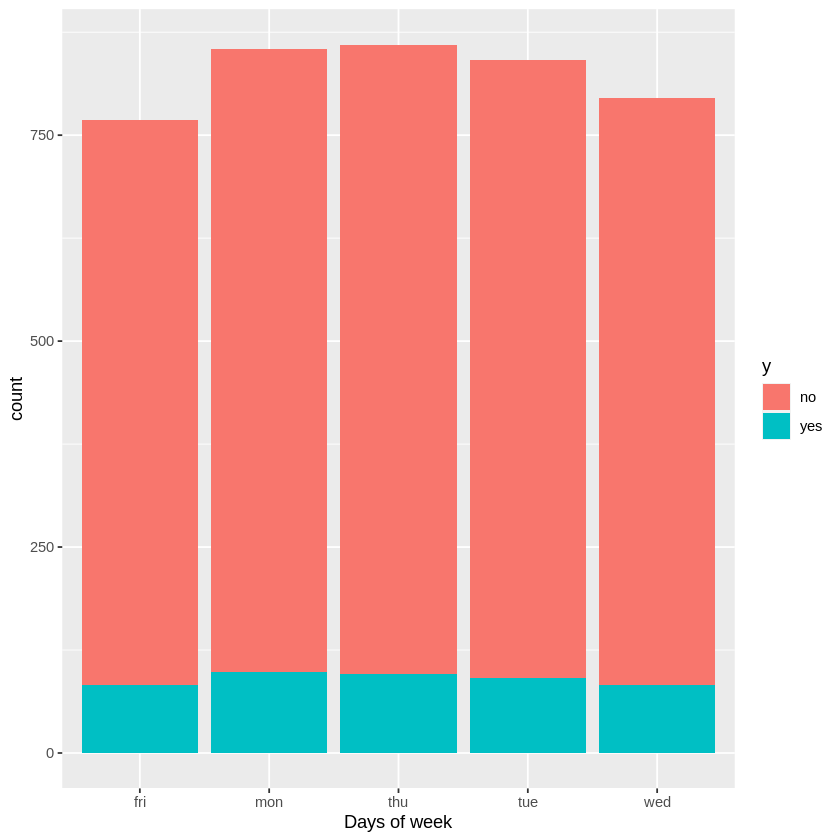

In [13]:
ggplot(bank_data, 
       aes(x = day_of_week, fill = y)) +
  geom_bar() + 
  labs(x = "Days of week")

In [17]:
days <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday")
sub_prop <- c(prop_days$prop_mon, prop_days$prop_tue, prop_days$prop_wed, prop_days$prop_thu, prop_days$prop_fri)

df <- data.frame(days, sub_prop)
df

days,sub_prop
<chr>,<dbl>
Monday,0.5274854
Tuesday,0.5362663
Wednesday,0.5672956
Thursday,0.5244186
Friday,0.5872396


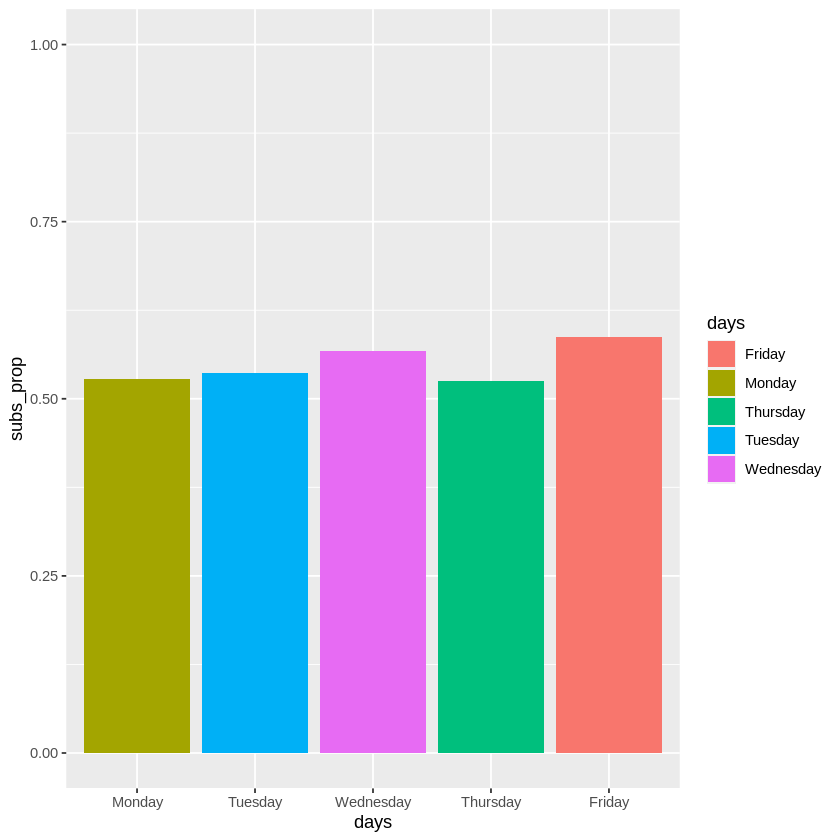

In [24]:
order <- c("Monday", "Tuesday", "Wednesday", "Thursday","Friday")

bar_plot <- ggplot(df, aes(x = days, y = subs_prop, fill = days)) +
  geom_bar(stat = "identity")+
  scale_x_discrete(limits = order)+
  coord_cartesian(ylim = c(0, 1))

bar_plot

# Methods: Plan


# References